<a href="https://colab.research.google.com/github/selenajoetwilliams/Fashion-MNIST/blob/main/image_classifier_modified_for_FER_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am following this image classification tutorial on pytorch documentation:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

I plan to adapt it to the FER dataset which is conveniently stored in torchvision datasets

In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Load & process data

# Notes from this section:

*   differences between trainset & testset: 
    * train = True for trainset, False for testset
*   other notes about train & set set
    * num_workers is a command that specifies parralel processing computation allocations -- just set it to a positive integer (2-8 is standard)
    * download=True because we want to download the datasets locally


**NOTE** the difference in transform functions between this and the image_classifier model in pytorch. The image_classifier model in pytorch has a transform function that works for RGB images, but the one here works for grayscale images.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

# batch sizes of 32, 64, or 128 are commonly used in many deep learning applications
batch_size = 4

trainset = torchvision.datasets.FER2013(root='/content/drive/MyDrive/', split="train", transform=transform) # 80% for training, 20% for testing
# training and testing (80-20) OR training, validation, & testing (70-30-30)
# use first 80% of rows
# most sphisticated: np.random -- randomly select 80% of data 


# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FER2013(root='/content/drive/MyDrive', split="test", transform=transform)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')


# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# for FER it will be: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

# Visualizing Data
questoins: is dataiter & next(dataiter) only possible with iterable datasets? Pytorch documentaiton notes 2 kinds of datasets: iterable & map

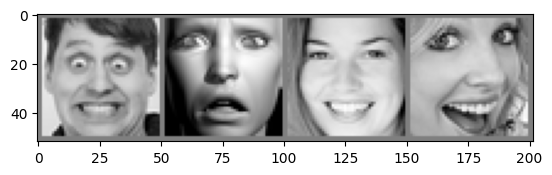

Surprise Fear  Happy Happy


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 2. Defining a Convolutional Neural Network
* note that this takes in 3-channel (RGB) images. If you want to see an example of 1-channel images, check the neural networks section from before this module in the pytorch 60 minute blitz

Q: do all NN classes take in nn.Module? why?

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    # def __init__(self):
    #     super().__init__()
    #     self.conv1 = nn.Conv2d(3, 6, 5)
    #     self.pool = nn.MaxPool2d(2, 2)
    #     self.conv2 = nn.Conv2d(6, 16, 5)
    #     self.fc1 = nn.Linear(16 * 5 * 5, 120)
    #     self.fc2 = nn.Linear(120, 84)
    #     self.fc3 = nn.Linear(84, 10)

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        print("in this forward pass, x is ") # TODO: REMOVE THIS
        print(x)


net = Net() # this creates an instance of the Net class, which has the constructor & forward function defined above


# 3. Define the Loss Function & optimizer
Here we use Classification Cross-Entropy loss & SGD (stochastic gradient?) with momentum

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network
This is interesting: to do this: simply loop over the data iterator and feed the data into the network & optimize
**note that we only have 2 epochs -- this is a sign of a really simple model. when you have time, go through and increase the epochs**

In [6]:
for epoch in range(2):  # loop over the dataset multiple times
    print('epoch ' + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        '''
        the 4 lines below represent one iteration through the training data

        about the bottom 2 lines: 
        Together, these two lines of code represent one iteration of the training process. 
        The loss is computed for the current batch of data, the gradients are calculated, 
        and the optimizer updates the model parameters accordingly. This process is repeated 
        for multiple iterations (or "epochs") until the model's performance on a validation 
        set reaches a satisfactory level.
        '''

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) # criterion is just a fancy word for the loss function!
        loss.backward() 
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

epoch 0
[1,  2000] loss: 1.803
[1,  4000] loss: 1.701
[1,  6000] loss: 1.635
epoch 1
[2,  2000] loss: 1.550
[2,  4000] loss: 1.509
[2,  6000] loss: 1.457
Finished Training


# Saving the model
Let's quickly save our trained model:

In [7]:
PATH = './fer2013_net.pth' # Note that this name should change when we adapt this to fer dataset
torch.save(net.state_dict(), PATH)

## 5. Visualizing the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.
Okay, first step. Let us display an image from the test set to get familiar.

In [26]:
import pandas as pd
import numpy as np
import torch

test_df = pd.read_csv('/content/drive/MyDrive/fer2013/test.csv')

print("top 5 rows are printed at bottom")
rows, cols = test_df.shape
print("rows: " + str(rows) + " cols: " + str(cols))



# test_df.head().loc[:"pixels"]

test_df
test_df.columns

print(test_df.pixels)

np_arr = test_df.pixels.to_numpy # convert to numpy array
# torch.dtype(np_arr) # error: cannot create 'torch.dtype' instances
# print(np_arr.shape()) # error: 'function' object has no attrbute 'shape'

# np_2d = np_arr.reshape(48, 48) # reshape 
# print(np_2d.shape())



# for i in range(10):
#   print(test_df[1][i])

top 5 rows are printed at bottom
rows: 7178 cols: 1
0       254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1       156 184 198 202 204 207 210 212 213 214 215 21...
2       69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3       205 203 236 157 83 158 120 116 94 86 155 180 2...
4       87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
                              ...                        
7173    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
7174    178 174 172 173 181 188 191 194 196 199 200 20...
7175    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
7176    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
7177    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 7178, dtype: object


In [ ]:
import pandas as pd

'''
high level attempt:
convert csv to pandas dataframe 
use numpy reshape to reshape from 1D array of pixels to 2D 48 x 48 pictures
extract first 4 images from df, print them with imshow function
'''

# train_df = pd.resd_csv('/content/drive/MyDrive/fer2013/train.csv')
# train_df.head()

test_df = pd.read_csv('/content/drive/MyDrive/fer2013/test.csv') # 
print(type(test_df))
# test_df = test_df.apply(pd.to_numeric)

test_df.head(10)

pixels = test_df.values

# read test file
# have some accuracy #s on test dataset & compare them w/ ground truth 
# switch datasets

im_list = [] 
#instead of pixels[i], im_list.append(____)
# once you split, make sure it's not a string, if so, you'll need 
# need to pass in a list of nums into im_show

# previously I wasn't iterating over pixels --> would have to use map function to make old way work, use enumerate instead
for i, val in enumerate(pixels): # enumerate makes a dict which has idx, value
    print(val[0])
    print(type(val[0]))

    image = []
    for pixel in val[0].split(' '):
      image.append(pixel)
    print("image is ")
    print(image)
    im_list.append(image)
    print("im_list is ")
    print(im_list)
    # make new df and append the new image
    # the string can be converted into list, but that list might still be s tring
    # iterate over list & convert every string into a float
    # create a new empty list & append the new list of images to that list

    # print(val[0])
    # print(val.shape)
    # pixels[i] = val.strip('"')
    # print(pixels[i])

# idx, pixels = test_df
for i in range(3):
  # pixels[i].strip()
  print(pixels[i])

# pic_list = test_df.split("'") # split on quotes 
# pic_list = test_df.values.tolist() # converts dataframe to list
# for i in range(3):
#   pic_list[i].strip("'")
#   print(i)

# for i in range(5):
#   print(pic_list[i])

# for i in pic_list: # for each image
#   i.read_csv(delimiter=' ')

def imshow(img):
    # print("image is ")
    # print(img)
    # print(type(img))
    # Convert pixel values to numpy array and reshape
    npimg = np.array(img, dtype=float).reshape(48, 48) / 255.
    # npimg = np.array(img).reshape((48, 48))

    # Display image
    plt.imshow(npimg, cmap='gray')
    plt.show()

# for i in range(4):
#   pixels = test_df.iloc[i][pixels].values

for image in pixels:
    print("image type is ")
    print(type(image))
    print(f"image {i}")
    imshow(image)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




133 132 132 131 130 128 127 122 100 51 35 28 22 22 24 30 29 33 42 53 63 70 80 75 74 73 70 70 72 70 68 63 56 41 29 33 39 71 142 189 202 192 189 191 196 201 209 215 133 132 132 131 129 128 124 116 63 33 27 26 25 24 30 33 43 49 60 66 69 77 82 82 81 77 73 72 71 71 69 64 62 57 40 28 29 46 73 102 175 205 200 196 192 189 193 198 131 132 131 131 128 125 122 91 39 29 28 29 24 24 28 38 52 63 70 76 80 86 88 87 84 84 82 77 74 72 70 66 63 63 57 40 30 33 45 36 50 107 152 160 176 195 202 202 131 131 130 130 127 123 93 45 35 33 27 22 21 23 30 44 62 70 78 83 87 90 91 89 90 86 84 83 81 73 71 71 67 63 63 54 41 28 37 47 41 43 77 104 111 124 139 160 130 130 131 128 125 92 38 31 27 21 18 19 23 31 44 66 71 80 85 89 89 89 90 92 91 89 87 88 86 82 76 75 72 64 63 59 50 37 34 45 50 58 56 80 109 109 106 106 132 130 129 128 111 46 27 26 25 26 27 31 43 53 68 79 81 85 89 89 90 93 96 98 94 96 95 95 93 87 83 79 73 69 67 65 58 41 32 43 45 53 55 49 83 112 115 114 130 131 130 128 102 39 31 27 25 37 51 64 73 82 83 86 86 8

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




82 78 98 126 159 179 178 183 185 185 185 185 187 187 191 198 203 204 205 205 206 204 201 198 195 193 191 186 179 172 156 130 72 49 57 67 85 107 118 120 122 120 123 122 121 120 122 121 92 90 109 140 157 174 175 186 187 186 188 185 185 187 194 197 202 206 205 205 206 204 203 199 197 194 193 191 189 185 176 159 121 53 50 65 74 94 112 121 121 119 120 121 122 121 121 120 113 103 120 147 158 168 174 180 182 188 185 189 191 192 198 200 203 205 202 201 201 199 201 197 192 190 190 188 190 191 183 176 162 84 32 56 70 91 107 110 121 120 120 121 121 122 122 120 94 104 123 145 154 162 171 176 181 185 186 191 191 195 199 202 203 203 204 205 202 199 201 195 191 192 190 186 187 189 185 184 174 146 52 43 63 80 88 116 118 122 121 121 121 122 121 121 128 126 119 141 146 163 169 173 177 181 187 189 194 196 200 203 203 203 202 203 201 201 203 199 194 193 192 189 184 187 187 184 173 175 104 36 68 80 80 100 122 119 121 121 121 122 120 120 138 105 121 139 147 168 168 162 167 175 183 188 194 197 196 201 198 2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




141 139 138 147 150 134 117 103 118 125 130 131 151 75 9 20 24 19 26 32 31 34 38 32 51 39 40 35 30 34 32 31 21 15 19 19 13 20 11 14 8 6 4 6 8 3 5 5 140 140 141 141 151 141 126 105 113 123 128 141 99 10 21 24 22 23 39 40 48 56 68 70 92 75 74 85 63 48 41 30 36 31 24 26 30 17 16 12 10 7 5 4 8 5 4 5 142 139 139 142 151 144 131 111 108 122 136 123 14 21 17 21 43 53 61 73 86 86 97 118 119 122 125 121 107 103 113 96 61 60 50 28 25 34 18 18 17 14 7 5 4 7 5 6 146 139 140 141 148 147 135 119 107 117 138 57 5 22 33 50 59 64 71 79 84 94 103 120 114 116 127 121 112 115 110 109 101 91 68 61 51 34 31 21 22 20 11 5 6 9 6 6 143 142 140 140 145 152 140 125 106 120 112 12 26 38 54 53 56 67 73 81 93 97 103 111 113 124 138 131 116 114 107 101 86 81 75 77 79 74 56 42 25 20 20 13 3 7 6 6 145 142 140 141 144 151 145 131 109 120 53 13 47 48 53 58 61 71 74 85 97 103 110 114 122 136 137 133 130 130 113 103 93 83 78 76 72 67 72 66 50 43 33 17 6 5 7 6 144 143 140 140 143 152 150 134 119 102 14 32 51 47 55 59 64 7

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Next, let's load back in our saved model

# Loading the model

Note: saving and re-loding the model ins't necesary here -- we only dd it to illustrate how to do so :)

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Running the model on 4 test images
Okay, now let's see what the neural network thinks the 4 examples above are:
Note: this is a good practice so gauge how the model is generally doing before running it on the whole dataset (which can be time and computationally expensive)

In [18]:
outputs = net(images)
print(outputs) # this isn't necessary

tensor([[-7.7250e-01, -2.8172e+00,  2.2375e-02,  2.2813e+00, -1.4869e+00,
          7.6568e-01,  3.8208e-01],
        [ 1.1118e+00, -2.1249e+00,  1.1210e+00,  1.9591e-03, -1.8145e-01,
          6.8301e-01, -1.2336e+00],
        [-1.4709e+00, -2.6833e+00, -4.1442e-01,  4.2850e+00, -1.6415e+00,
          1.9262e-01, -3.3771e-01],
        [-3.4177e-02, -2.4555e+00,  1.2642e+00,  1.2276e+00, -5.4713e-01,
          1.1718e+00, -1.2805e+00]], grad_fn=<AddmmBackward0>)


The outputs are energies for the 7 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:

In [19]:
# torch.max returns [maximum_tensor_value, index of the class with the highest probability]
# prediced is a list of the indices of the labels
_, predicted = torch.max(outputs, 1) # interestingly, '_,' is used to discard the first thing that torch.max returns

# the label index is passed into the classes list to return the string representing the class label (at the predicted index)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

# this is unecessary, but helps to understand what each variable is
print(predicted)
print(classes)

Predicted:  Happy Fear  Happy Fear 
tensor([3, 2, 3, 2])
('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')


# Running the model on the entire test dataset
Now we will run the model on the whole test dataset to see how it performs. Notice that we use simple counters to track & compute the average accuracy

Another key thing to note: we **use torch.no_grad() when we're not training the model,** because we don't need to compute gradients during the testing phase & it would just waste space in memory

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) # (outputs, 1) returns the class predictions like [3, 1, 8, 0] above
        # collct the correct predictions for each class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on 10,000 test images: {100 * correct // total} %')

TypeError: ignored

That looks way better than chance, which is 10% accuracy (picking a class at random). Sees llike the model learnt something. 

Hmm, what are the classes that performed well and the ones that didn't?

# Exploring which classes performed well & which didn't

Note: Notice that you will get different accuracies for each class every time you train the neural network. This is because 

In [ ]:
correct_pred = {classname: 0 for classname in classes} # using dictionary comprehension here
total_pred = {classname: 0 for classname in classes} 

# again, no gradients are needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions): # for each label
            if label == prediction: # if the (actual) label = the (expected) prediction 
                correct_pred[classes[label]] += 1 # increment correct predictions counter
            total_pred[classes[label]] += 1 # increment total predictions 

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Okay, so what next? How do we run these neural networks on the GPU?

# Training on GPU 
## using "if torch.cuda.is_available"
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU. 
Let's first deine our device as the first visible cuda device is we have CUDA available:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
# Now print device to see if we are running on the GPU (cuda) or CPU
print(device) 

### Note: the rest of this sections assumes that device is a CUDA device

Theses methods will recursively go ove all modules and convert their parameters and buffers to CUDA tensors:

.. code:: python
### Note: if you get an **error related to no NVIDIA driver** it just means you need to **change runtime type** from CPU -> GPU by clicking Runtime > Change Runtime Type above. Google Collab runs code remotely on google servers and gives you the choice between running on CPU or GPU.


In [ ]:
net.to(device)

Remember that you will have to send the inputs and targets at every step to the GPU too:
.. code:: python

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice a MASSIVE speedup compared to CPU? Because your network is really small. 

**Exercise:** Try increasing the width of your network (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d -- they need to be the same number), see what kind of speedup you get.

**Goals Achieved:** 


*   Understanding PyTorches Tensor librrary and neural networks at a high level
*   Train a small neural network to classify images



#Training on multiple GPUs
If you want to see an even more MASSIVE speedup using all of your GPUs, please check out :doc:data_parallel_tutorial.

# Where do I go next?

*   :doc:Train neural nts to play video games </intermediate/reinforcement_q_learning>
*   Train a state-of-the-art ResNet network on imagenet_
*   Train a face generator using Generative Adversarial Networks_
*   Train a word-level langugage model using Recurrent LSTM networks_
*   More examples_
*   More tutorials_
*   Discuss PyTorch on the Forums_
*   Chat with other users on Slack_








## The tutorial I followed included del dataiter here, but...

del dataiter deletes the variable dataiter from memory, **while this could potentially free up some memory resources, this is typically not necessary in PyTorch as the framework handles memory management automatically.** 

In [ ]:
del dataiter